# **Novel Application of an Image Classification Model** - Employing Object Detection To Identify Road Cleanliness Conditions
##### *December 12, 2023*
---
---
---
---

# Introduction:

The problem we face is that in many countries around the world, from urban and suburban areas, as well as rural impoverished areas, the maintenance of road cleanliness is a significant challenge that directly impacts public health, safety, and the overall aesthetic appeal of the community.
As a result, there's a growing need for an efficient, automated system that can consistently monitor road conditions and classify them based on cleanliness levels.

Our response to this problem considers a machine learning solution.
The objective is to train a convolutional neural network to accurately classify images into the 'clean' or 'dirty' categories. This model can be implemented into traffic cameras and other monitoring systems which can serve as the basis for the decision making of garbage collection solutions, it can also help in the decision to deploy workers to clean critical areas. The expected outcome is to have cleaner and safer roads, reducing driving hazards, and establishing and maintaining a cleaner environment.


### Solution:
This notebook addresses the task of binary classification for clean and littered road images using the MobileNetV2 model. The problem involves distinguishing between two classes based on images of road conditions.

We use the MobileNet_V2 from Google as our pre-trained model, we will utilize it for:
- **Object Detection:** We have an image and we want it to select the most likely objects contained in the image, in our case it's garbage on roads.
- **Transfer Learning Detection:** We have a different set of binary (clean/littered) objects that we want to detect. In this case we can take the feature vector of the pretrained model and retrain it on our data.

### Methodology:
The MobileNetV2 model is built upon and retrained utilizing transfer learning. We train it on the clean/littered road dataset which is a dataset specifically optimized for image classification. The dataset is split into training and validation sets at a 7:3 ratio, with data augmentation applied. The model is trained using categorical cross-entropy loss and evaluated on both validation and test sets.

### Expected Outcomes:
The expected outcome from the retraining of the model is for it to accurately, with at least 80% accuracy, classify images from the dataset.

The expected outcomes involve observing improvements in the model's accuracy and loss during training. Validation and testing metrics, such as accuracy and loss, will be visualized through plots. Additionally, the confusion matrix and classification report will provide insights into the model's performance on unseen data, offering a detailed analysis of its ability to distinguish between clean and dirty road images.

---
---

##### Initial Setup

In [ ]:
import os
from random import randint

import numpy as np
import pandas as pd
import cv2
import requests
from PIL import Image
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 1 Data Preperation

## Load Model

In [ ]:
model_name = "mobilenetv2-035-128"  # Google's MobileNetV2 image classification model

model_image_size_map = {
  "mobilenetv2-035-128": 128,
}

model_handle_classifier = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"
model_handle_feature_vector = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-feature-vector/versions/2"

classifier = hub.load(model_handle_classifier) # Load the model

#@markdown The TensorFlow Hub library is used to load the pre-trained MobileNetV2 model specified by the given link. This model will later be utilized for general object detection and transfer learning detection tasks tuned for road images.

## Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

folder_path = '/content/drive/MyDrive/'
%cd {folder_path}

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
# Data Loading and Preprocessing
images_path = 'cleandirty-road-classification/Images/'

#  Read metadata CSV file containing filenames and labels, specify class names ('clean', 'dirty').
labels_df = pd.read_csv('cleandirty-road-classification/metadata.csv')
print('labels dataframe: \n', labels_df.head(), '\n\n')

class_names = ('clean', 'dirty')
num_classes = len(class_names)

img_size = (128, 128, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')

labels = []
images = []

for image in labels_df.iloc:
    image_path = os.path.join(images_path, image[0])
    image_data = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if image_data is not None:
        resized_image = cv2.resize(image_data, img_size[0:2])
        rgb_image = resized_image[:, :, ::-1] # Convert BGR to RGB
        images.append(np.asarray(rgb_image))

        # One-hot encode the labels
        label = np.zeros(num_classes)
        label[int(image[1])] = 1
        labels.append(label)
    else:
        print(f"Error reading image from {image_path} - File may not exist or be inaccessible")

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')

labels dataframe: 
         filename  label
0    dirty_2.jpg      1
1   clean_36.jpg      0
2   clean_31.jpg      0
3   dirty_69.jpg      1
4  clean_113.jpg      0 


2 classes: ('clean', 'dirty')
image size: (128, 128, 3)

labels shape: (237, 2)
images shape: (237, 128, 128, 3)


There are 237 samples in the dataset.

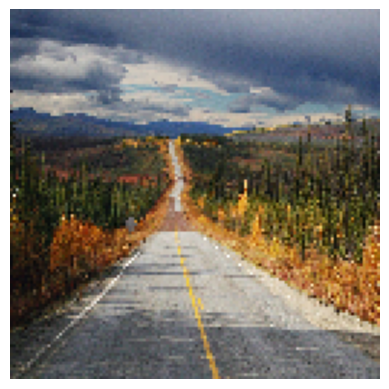

In [ ]:
# Sample image from dataset
plt.axis('off')
plt.imshow(images[100]);

## Utilities
These are just some helper functions for printing the images and processing for it to work with OpenCV.

In [ ]:
def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

In [ ]:
def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

# 2 Testing The Pre-Trained Model
To set a baseline, we'll initially use the default pre-trained model to analyze some of the road pictures and observe the features that the model identifies.

In [ ]:
max_dynamic_size = 512
if model_name in model_image_size_map:
  image_size = model_image_size_map[model_name]
  dynamic_size = False
  print(f"Images will be converted to {image_size}x{image_size}")
else:
  dynamic_size = True
  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []

with open(downloaded_file) as f:
  imagenet_labels = f.readlines()
  classes = [l.strip() for l in imagenet_labels]

#@markdown The ImageNet model is already setup with pre-defined classes by Google. We'll load and create a map of class labels (classes) to help  interpret the model's predictions.

Images will be converted to 128x128
10484/10484 [==============================] - 0s 0us/step


### Sample Image 1
On a simpler image, specifically one of the 'clean' labelled images, the model is fairly capable.

(1)  864 - totem pole: 0.6335919499397278
(2)  920 - street sign: 0.04720831289887428
(3)  705 - parking meter: 0.032054416835308075
(4)  921 - traffic light: 0.027224382385611534
(5)  782 - scoreboard: 0.014852671884000301


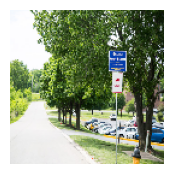

In [ ]:
# Run model on image
demoImage = preprocess_image(images[140])
probabilities = tf.nn.softmax(classifier(demoImage)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(demoImage, '')

The output shows the top 5 predicted classes, their class names, and corresponding probabilities.
We can see that it is capable of identifying various objects within the image, and does so with decent accuracy. Notice it doesn't classify the general things in the image such as roads and trees.

### Sample Image 2
The model clearly falls apart when we feed it a more chaotic image, like one of the 'dirty' images in the dataset.

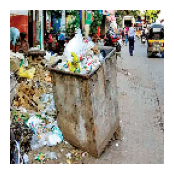

In [ ]:
demoImage = preprocess_image(images[30])
show_image(demoImage, '')

(1)  161 - Afghan hound: 0.14450502395629883
(2)  413 - ashcan: 0.08267375081777573
(3)  492 - chain saw: 0.05906657874584198
(4)  654 - milk can: 0.047151368111371994
(5)  583 - grocery store: 0.039319589734077454


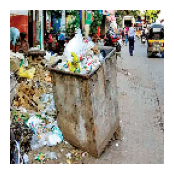

In [ ]:
probabilities = tf.nn.softmax(classifier(demoImage)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)

includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(demoImage, '')

# 3 Training
Training the ImageNetV2 model on custom data using transfer learning.

## Transfer Learning
We gain greater control over defining our problem and selecting labels. In our approach we're utilizing the feature vector from ImageNet and training it on a subset of clean/dirty images.

The goal of our project is to create a model capable of identifying clean versus literred roads, thus we will follow up by assessing its performance in adapting to this binary classification problem (this also aligns with what the dataset is designed for).

*NOTICE we are using* ***Feature Vector*** *and not* ***Classifier***

In [ ]:
pixels = model_image_size_map.get(model_name, 128)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 4

print(f"Selected model: {model_name} : {model_handle_feature_vector}")
print(f"Input size {IMAGE_SIZE}")

Selected model: mobilenetv2-035-128 : https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-feature-vector/versions/2
Input size (128, 128)


##### Sample of the images and labels in the dataset

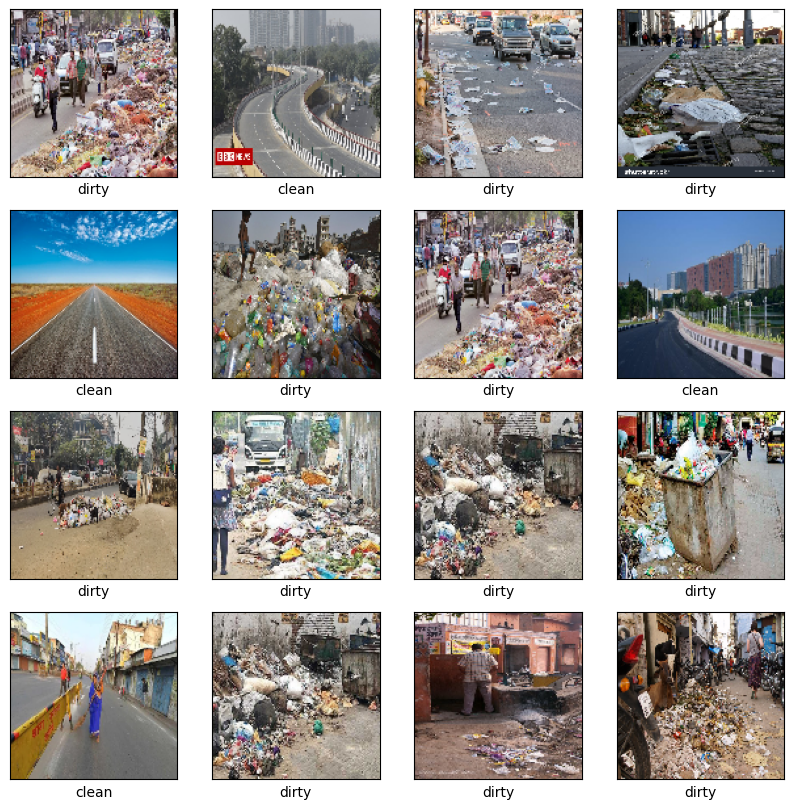

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for x in range(4):
    for y in range(4):
        i = randint(0, len(images) - 1)

        axs[x][y].imshow(images[i])
        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])

plt.show()

### Define test/train split
90% train, 10% test split.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}')

train images shape: (213, 128, 128, 3)
train labels shape: (213, 2)

validation images shape: (24, 128, 128, 3)
validation labels shape: (24, 2)


### Data Augmentation
These generators apply on-the-fly data augmentation techniques during training to enhance the diversity of the training dataset:
- For the train_images_generator, we apply: shear, rotation, zoom, vertical flip, and horizontal flip.
- The validation_images_generator applies vertical flip and horizontal flip.
We apply less aggressive augmentation to the validation set to ensure that the model generalizes well to unseen data.

In [ ]:
# ImageDataGenerator for train images
train_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.3,
                                                                         rotation_range=15,
                                                                         zoom_range=0.3,
                                                                         vertical_flip=True,
                                                                         horizontal_flip=True)
train_images_generator = train_images_generator.flow(X_train, y=y_train)

# ImageDataGenerator for validation images
validation_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True,
                                                                              horizontal_flip=True)
validation_images_generator = validation_images_generator.flow(X_val, y=y_val)

### Building the model
Here we're building the model architecture for binary classification. Note the following:
- A dropout layer with a dropout rate of 0.2 is added to prevent overfitting.
- The pre-trained MobileNetV2 model is added to the model definition.

In [ ]:
do_fine_tuning = False
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle_feature_vector, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

#@markdown **Interpretation of the output:** The total number of parameters in the model is 412770, with 2562 being trainable and 410208 non-trainable. The non-trainable parameters come from the pre-trained MobileNetV2 model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              410208    
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 412770 (1.57 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 410208 (1.56 MB)
_________________________________________________________________


In [ ]:
# creating Model Checkpoint
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}')

## Training Model on Dataset
Retraining the model on our custom Garbage Classification dataset in order to tune the models ability to detect objects to our specific use case.

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

train_size = X_train.shape[0]
valid_size = X_val.shape[0]
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_images_generator,
    epochs=20,
    verbose=1,
    validation_data=validation_images_generator, callbacks=[checkpoint_callback])

#@markdown In just about 4 epochs we already have around 90% accuracy.

#@markdown Epoch 13 appears to be a strong candidate for the best epoch as it has the highest validation accuracy (0.9583) and relatively low validation loss (0.4237)

Epoch 1/20
7/7 [==============================] - 17s 2s/step - loss: 0.7571 - accuracy: 0.5775 - val_loss: 0.6558 - val_accuracy: 0.6667
Epoch 2/20
7/7 [==============================] - 9s 1s/step - loss: 0.6668 - accuracy: 0.6385 - val_loss: 0.6041 - val_accuracy: 0.6250
Epoch 3/20
7/7 [==============================] - 10s 2s/step - loss: 0.6548 - accuracy: 0.6526 - val_loss: 0.4876 - val_accuracy: 0.8333
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 0.6537 - accuracy: 0.6901 - val_loss: 0.4464 - val_accuracy: 0.9167
Epoch 5/20
7/7 [==============================] - 9s 2s/step - loss: 0.6168 - accuracy: 0.7324 - val_loss: 0.4715 - val_accuracy: 0.8333
Epoch 6/20
7/7 [==============================] - 9s 1s/step - loss: 0.6085 - accuracy: 0.7183 - val_loss: 0.4677 - val_accuracy: 0.8750
Epoch 7/20
7/7 [==============================] - 8s 1s/step - loss: 0.5874 - accuracy: 0.6901 - val_loss: 0.4289 - val_accuracy: 0.9167
Epoch 8/20
7/7 [=======================

In [ ]:
# Save the trained model
model.save("mobilenetv2_garbage_classifier_retrained_model.h5");

# 4 Validation
In this analysis, we delve deeper into the performance of our object detection & binary classification model trained on the 'cleandirty-road-classification' dataset using MobileNetV2. We aim to understand not just the accuracy of the model, but also how it performs in terms of error types, its ability to balance precision and recall, and its overall reliability.

## Accuracy and Loss Plots

In [ ]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(accuracy))

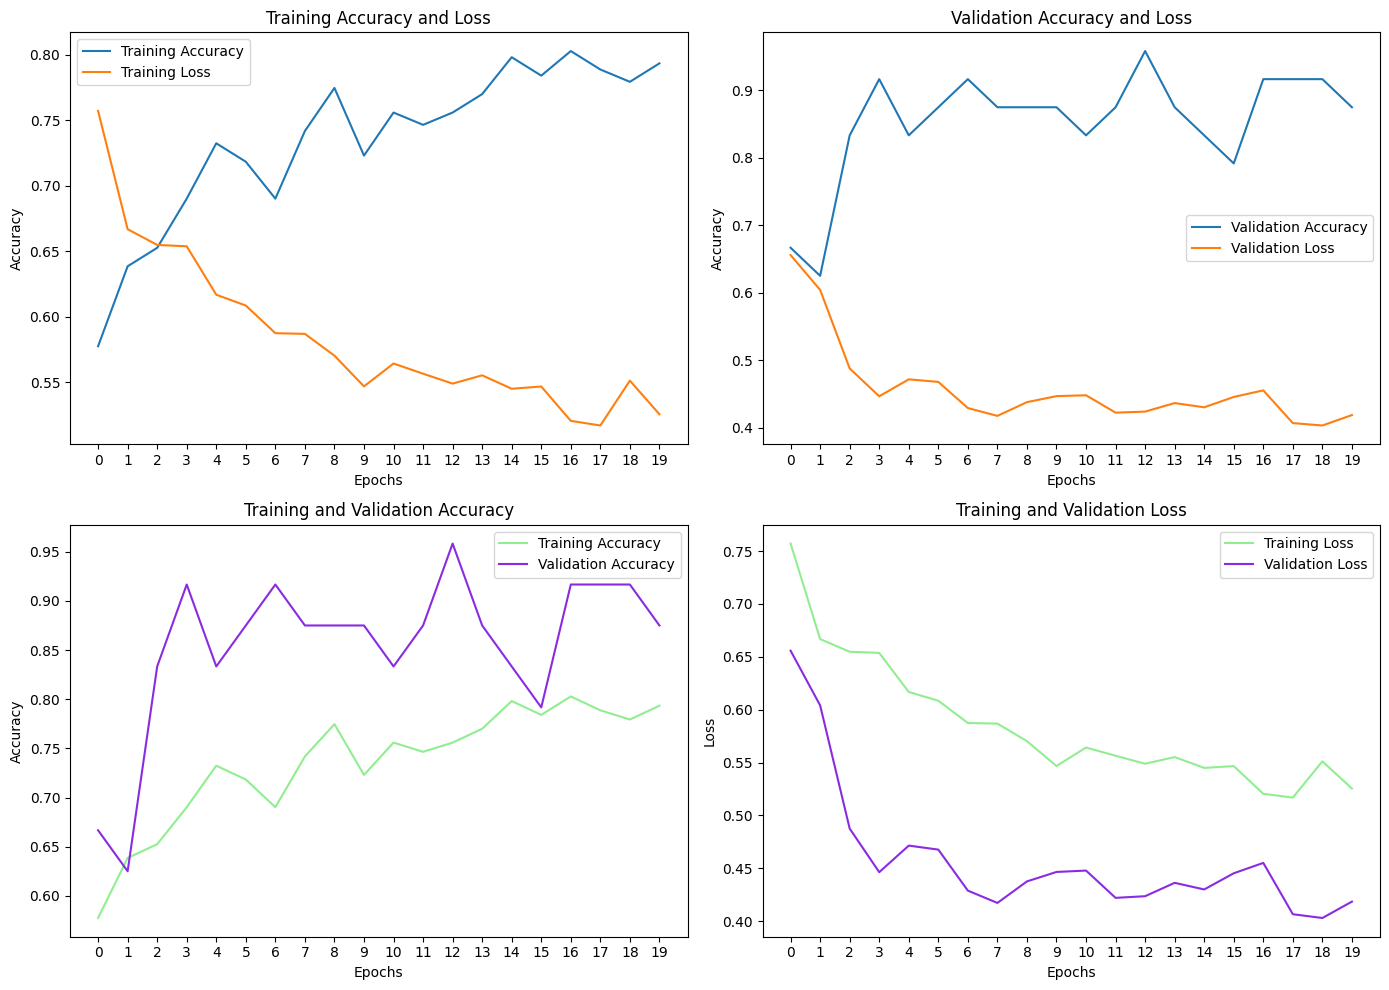

In [ ]:
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.title('Training Accuracy and Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.title('Validation Accuracy and Loss')

plt.subplot(2, 2, 3)
plt.plot(epochs, accuracy, label='Training Accuracy', color='lightgreen')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='blueviolet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(epochs, loss, label='Training Loss', color='lightgreen')
plt.plot(epochs, val_loss, label='Validation Loss', color='blueviolet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

#@markdown The validation accuracy quickly stabilizes following epoch 3 staying between ~80% to ~90%

## Predictions

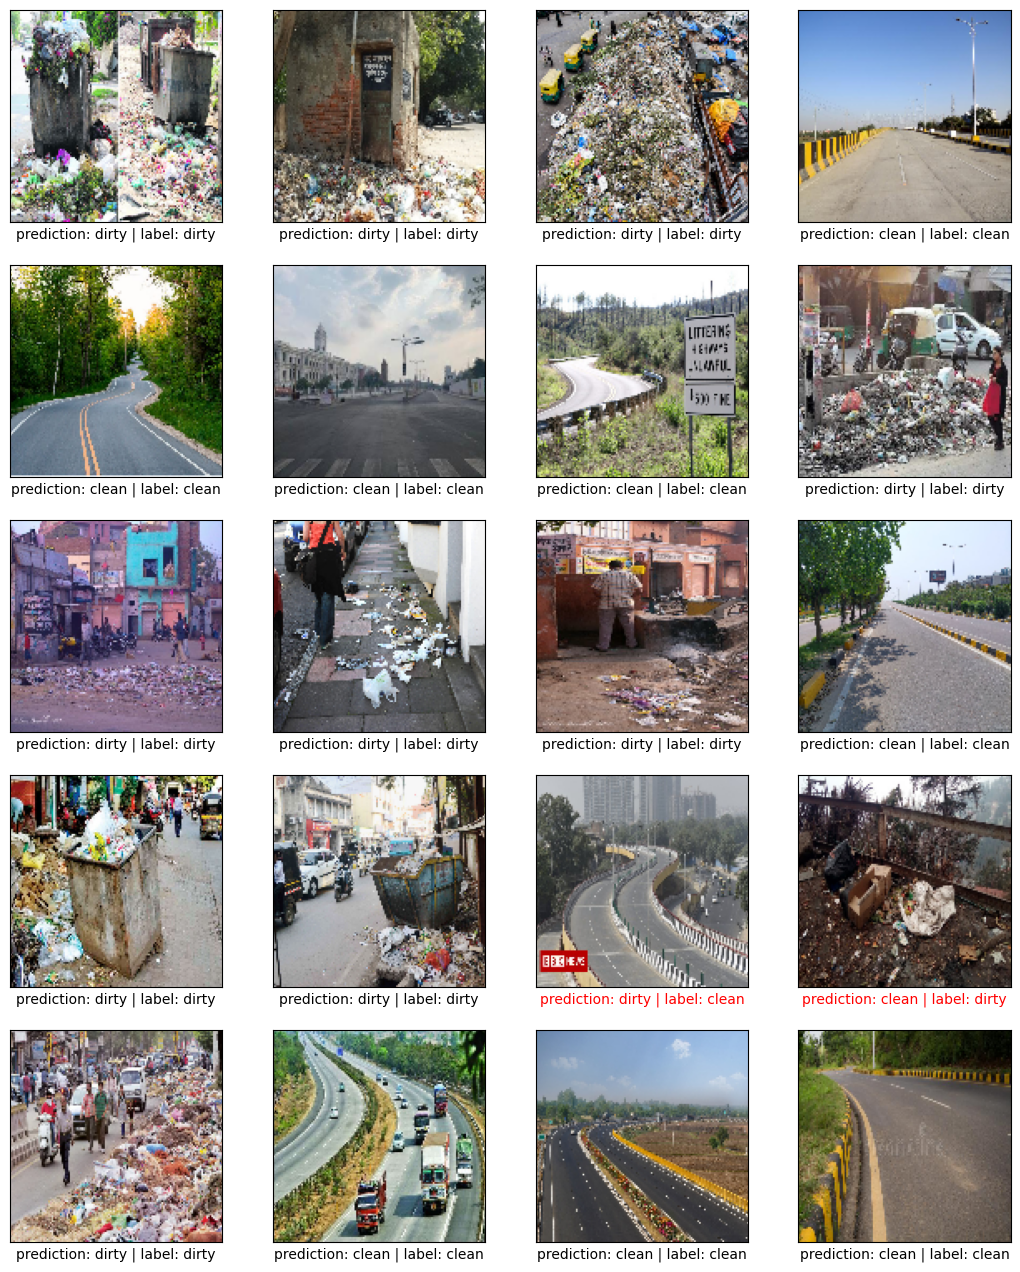

In [ ]:
fig, axs = plt.subplots(5, 4, figsize=(13, 16))

i = 0
for x in range(5):
    for y in range(4):
        prediction = model.predict(X_val[i][None, ...], verbose=0)[0]

        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])

        if np.argmax(prediction) != np.argmax(y_val[i]):
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}', color='red')
        else:
            axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')

        axs[x][y].imshow(X_val[i])

        i += 1
plt.show()

In [ ]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

### Classification Report

In [ ]:
print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

       clean       0.90      0.90      0.90        10
       dirty       0.93      0.93      0.93        14

    accuracy                           0.92        24
   macro avg       0.91      0.91      0.91        24
weighted avg       0.92      0.92      0.92        24



#### Analysis Discussion:
The classification report, including precision, recall, and F1-score, offers a more nuanced view of the model's performance:

- **Precision:** Indicates accuracy of how many of the items identified as positive are actually positive.
- **Recall (Sensitivity):** Shows how many of the actual positive items were identified correctly.
- **F1-Score:** Harmonic mean of precision and recall, provides a balance between the two metrics; useful in cases of class imbalance.

These metrics provide insights into the trade-offs our model is making between identifying all relevant instances versus avoiding misclassification.

**Precision:**
- For the 'clean' class, the model has a precision of 0.90, suggesting predictions for 'clean',are correct 90% of the time.
- For the 'dirty' class, the precision is 0.93, indicating higher reliability in its 'dirty' predictions.

**Recall:**
- The recall of 0.90 for the 'clean' class means the model correctly identifies 90% of all 'clean' roads.
- The 'dirty' class has a slightly lower recall of 0.86, suggesting that the model misses 14% of the 'dirty' roads.

**F1-score:**
- The F1-scores for both 'clean' and 'dirty' are quite high (0.86 and 0.89, respectively), which suggests a well-balanced model.

**SupportL** Actual number of occurrences of each class in the dataset.
- There are 10 instances of 'clean' and 14 instances of 'dirty' in the test set.

**In terms of overall performance:**

The model has a high accuracy of 0.92, thus correctly predicting the class 92% of the time across the test dataset.

The macro average for precision, recall, and f1-score is 0.91, suggesting overall good performance across classes.

With a weighted average of 0.88 across precision, recall, and f1-score, the model shows strong performance, appropriately weighted for the class distribution.

The high precision for the 'dirty' class suggests that the model is very effective at identifying 'dirty' roads when it is confident, and the high recall for the 'clean' class indicates it's also good at identifying all the 'clean' instances. The balanced f1-scores suggest that the model has found a good equilibrium between precision and recall for both classes. However, the slightly lower recall for the 'clean' class could be an area to investigate further, possibly by providing the model with more examples of this class or by adjusting the decision threshold to improve the model's sensitivity to 'clean' roads.

### Confusion Matrix

1/1 [==============================] - 0s 26ms/step


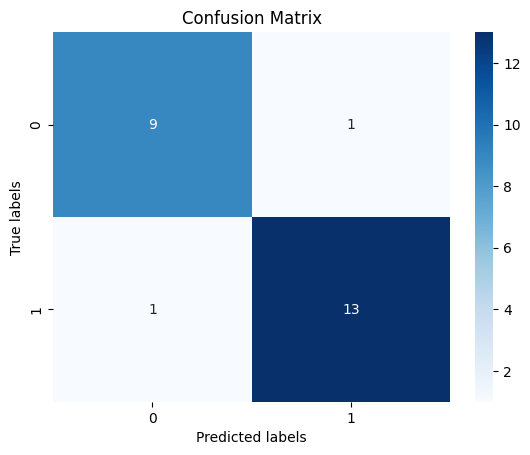

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Analysis Discussion

The confusion matrix provides a clear visualization of the model's performance in differentiating between the 'clean' and 'dirty' classes. From the matrix, we can observe:
- True Positives (TP): 9
- True Negatives (TN): 13
- False Positives (FP): 1
- False Negatives (FN): 1

This breakdown is helps us understand the kinds of errors our model is prone to. The model is very accurate in its classification.

### Error Analysis

Index: 14, Predicted: dirty, True: clean


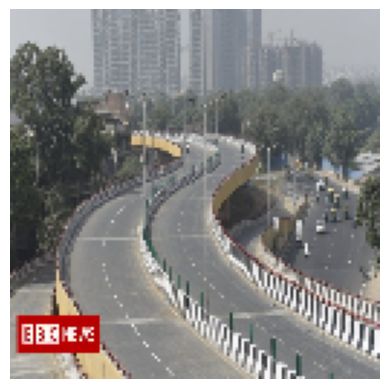

Index: 15, Predicted: clean, True: dirty


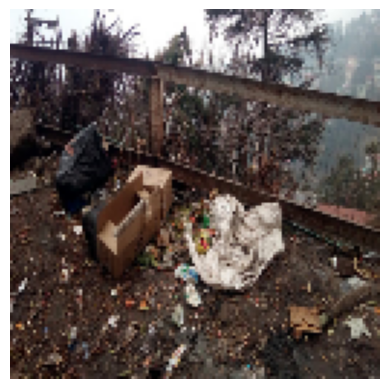

In [ ]:
error_indices = np.where(y_pred_classes != y_true)[0]
for i in error_indices[:10]:  # Display first 10 errors
    print(f"Index: {i}, Predicted: {class_names[y_pred_classes[i]]}, True: {class_names[y_true[i]]}")
    plt.axis('off')
    plt.imshow(X_val[i])
    plt.show()

#### Analysis Discussion:
By examining specific instances where the model failed to predict correctly, we identify patterns or data points that are challenging for the model. This analysis can help guide further data collection, feature engineering, or model tuning in the future.